# Reading general data of the problems


In [1]:
# coding=utf-8
from __future__ import division
import json
import os
import sys
import multiprocessing

# multiprocessing.set_start_method('spawn')
from MyUtils import clean_folder, read_files, shuffle_docs
from Word2Dim import Word2Dim

dataset_path = '.' + os.sep + 'pan19-cross-domain-authorship-attribution-training-dataset-2019-01-23'
outpath = '.' + os.sep + 'dev_out'

clean_folder(outpath)

infocollection = dataset_path + os.sep + 'collection-info.json'
problems = []
language = []
with open(infocollection, 'r') as f:
    for attrib in json.load(f):
        problems.append(attrib['problem-name'])
        language.append(attrib['language'])
print('Reading general data of the problems, done!')


Reading general data of the problems, done!


# Reading problem 1

In [2]:

problem = problems[0]
index = 0

# used for n_gram extraction and word indexing, a threshold which prevent words appearing lower than this value to be counted in calculations
tf = 5


infoproblem = dataset_path + os.sep + problem + os.sep + 'problem-info.json'
candidates = []
with open(infoproblem, 'r') as f:
    fj = json.load(f)
    unk_folder = fj['unknown-folder']
    for attrib in fj['candidate-authors']:
        candidates.append(attrib['author-name'])

candidates.sort()
# Building training set
train_docs = []
for candidate in candidates:
    train_docs.extend(read_files(dataset_path + os.sep + problem, candidate))
train_texts = [text for i, (text, label) in enumerate(train_docs)]
train_labels = [label for i, (text, label) in enumerate(train_docs)]
initial_train_size = len(train_labels)
train_texts, train_labels = shuffle_docs(train_texts, train_labels)
validation_size = len(train_texts) - initial_train_size
class_size = int(initial_train_size / len(set(train_labels)))
index_2_label_dict = {i: l for i, l in enumerate(set(train_labels))}
label_2_index_dict = {l: i for i, l in enumerate(set(train_labels))}
train_labels = [label_2_index_dict[v] for v in train_labels]
w2d = Word2Dim(lang= language[index])
train_tokenized_with_pos, train_tokenized_indexed = w2d.fit_transform_texts(train_texts, train_labels, tf= tf)

maxlen = len(max(train_tokenized_indexed, key=len))  # We will cut the texts after # words
embedding_dim = w2d.word_embedding.shape[1]

# preparing test set
ground_truth_file = dataset_path + os.sep + problem + os.sep + 'ground-truth.json'
gt = {}
with open(ground_truth_file, 'r') as f:
    for attrib in json.load(f)['ground_truth']:
        gt[attrib['unknown-text']] = attrib['true-author']

test_docs = read_files(dataset_path + os.sep + problem, unk_folder, gt)
test_texts = [text for i, (text, label) in enumerate(test_docs)]
test_labels = [label for i, (text, label) in enumerate(test_docs)]

# Filter validation to known authors
test_texts = [text for i, (text, label) in enumerate(test_docs) if label in label_2_index_dict.keys()]
test_labels = [label for i, (text, label) in enumerate(test_docs) if label in label_2_index_dict.keys()]

test_labels = [label_2_index_dict[v] for v in test_labels]

test_tokenized_with_pos, test_tokenized_indexed = w2d.transform(test_texts)
print("Reading problem 1, done!")

doc count to process:  819
process_doc, done!
word_set, ready!
fit_transform_texts is done!
doc count to process:  468
Reading problem 1, done!


# Data Extraction for Neural Net



In [3]:
from MyUtils import extract_n_grams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

n = 3
vocabulary = extract_n_grams(train_docs, n, tf)
vectorizer = CountVectorizer(analyzer='char', ngram_range=(n, n), lowercase=False, vocabulary=vocabulary)
n_gram_train_data = vectorizer.fit_transform(train_texts)

n_gram_train_data = n_gram_train_data.astype(float)

for i, v in enumerate(train_texts):
    n_gram_train_data[i] = n_gram_train_data[i] / len(train_texts[i])
n_gram_test_data = vectorizer.transform(test_texts)
n_gram_test_data = n_gram_test_data.astype(float)
for i, v in enumerate(test_texts):
    n_gram_test_data[i] = n_gram_test_data[i] / len(test_texts[i])
max_abs_scaler = preprocessing.MaxAbsScaler()
scaled_train_data_ngrams = max_abs_scaler.fit_transform(n_gram_train_data)
scaled_test_data_ngrams = max_abs_scaler.transform(n_gram_test_data)
max_abs_scaler = preprocessing.MaxAbsScaler()
scaled_train_data_words = max_abs_scaler.fit_transform(w2d.get_texts_vectorized_and_normalized(train_tokenized_indexed)[:, 1:])
scaled_test_data_words = max_abs_scaler.transform(w2d.get_texts_vectorized_and_normalized(test_tokenized_indexed)[:, 1:])
print("Done!")

Done!


In [4]:
print(scaled_train_data_words.shape)
print(scaled_test_data_words.shape)
print(len(w2d.word_index))

(819, 7623)
(468, 7623)
7623


In [8]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

from numpy import argmax
from sklearn.metrics import accuracy_score
from keras import layers, Input, callbacks
from keras.models import Sequential, Model, load_model
from keras import optimizers, regularizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

callbacks_list_neu = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=50,
    ),
    callbacks.ModelCheckpoint(
        filepath='my_model_neu.h5',
        monitor='val_loss',
        save_best_only=True,
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        verbose=1, 
        patience=20,
    )
]

callbacks_list_neu_ngrams = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=50,
    ),
    callbacks.ModelCheckpoint(
        filepath='my_model_neu_ngrams.h5',
        monitor='val_loss',
        save_best_only=True,
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        verbose=1, 
        patience=20,
    )
]

callbacks_list_neu_words = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=50,
    ),
    callbacks.ModelCheckpoint(
        filepath='my_model_neu_words.h5',
        monitor='val_loss',
        save_best_only=True,
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        verbose=1, 
        patience=20,
    )
]

callbacks_list_convnet = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=35,
    ),
    callbacks.ModelCheckpoint(
        filepath='my_model_convnet.h5',
        monitor='val_loss',
        save_best_only=True,
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        verbose=1, 
        patience=10,
    )
]

callbacks_list_stacked = [
    callbacks.ModelCheckpoint(
        filepath='my_model_stacked.h5',
        monitor='val_loss',
        save_best_only=True,
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        verbose=1, 
        patience=20,
    )
]

train_data = pad_sequences(train_tokenized_indexed, maxlen=maxlen)

test_data = pad_sequences(test_tokenized_indexed, maxlen=maxlen)

# X_train, X_val, y_train, y_val = train_data, test_data, to_categorical(train_labels), to_categorical(test_labels)
# X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels,
#                                                   test_size=validation_size,
#                                                   stratify=train_labels)
# X_scaled_train_data_words, X_scaled_val_data_words, _, _ = train_test_split(scaled_train_data_words, train_labels,
#                                                   test_size=validation_size,
#                                                   stratify=train_labels)
# X_scaled_train_data_ngrams, X_scaled_val_data_ngrams, _, _ = train_test_split(scaled_train_data_ngrams, train_labels,
#                                                   test_size=validation_size,
#                                                   stratify=train_labels)

y_train, y_val = train_labels[:initial_train_size], train_labels[initial_train_size:]
X_train, X_val = train_data[:initial_train_size], train_data[initial_train_size:]
X_scaled_train_data_words, X_scaled_val_data_words = scaled_train_data_words[:initial_train_size], scaled_train_data_words[initial_train_size:]
X_scaled_train_data_ngrams, X_scaled_val_data_ngrams = scaled_train_data_ngrams[:initial_train_size], scaled_train_data_ngrams[initial_train_size:]

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
# y_test = to_categorical(test_labels)
# print(X_train.shape)

print(y_train.shape)


(63, 9)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 32)                132896    
_________________________________________________________________
dropout_26 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 9)                 585       
Total para

63/63 [==============================] - 0s 4ms/step - loss: 3.3165 - acc: 0.7460 - val_loss: 3.0625 - val_acc: 1.0000
Epoch 54/500
63/63 [==============================] - 0s 4ms/step - loss: 3.3918 - acc: 0.6825 - val_loss: 3.0288 - val_acc: 1.0000
Epoch 55/500
63/63 [==============================] - 0s 4ms/step - loss: 3.2633 - acc: 0.7778 - val_loss: 2.9872 - val_acc: 1.0000
Epoch 56/500
63/63 [==============================] - 0s 4ms/step - loss: 3.2341 - acc: 0.6508 - val_loss: 2.9520 - val_acc: 1.0000
Epoch 57/500
63/63 [==============================] - 0s 4ms/step - loss: 3.2692 - acc: 0.6825 - val_loss: 2.9223 - val_acc: 1.0000
Epoch 58/500
63/63 [==============================] - 0s 4ms/step - loss: 3.2363 - acc: 0.7619 - val_loss: 2.8839 - val_acc: 1.0000
Epoch 59/500
63/63 [==============================] - 0s 4ms/step - loss: 3.2307 - acc: 0.7778 - val_loss: 2.8467 - val_acc: 1.0000
Epoch 60/500
63/63 [==============================] - 0s 4ms/step - loss: 3.1889 - acc: 0

63/63 [==============================] - 0s 4ms/step - loss: 2.1666 - acc: 0.9683 - val_loss: 1.8463 - val_acc: 1.0000
Epoch 116/500
63/63 [==============================] - 0s 4ms/step - loss: 2.1569 - acc: 0.9365 - val_loss: 1.8381 - val_acc: 1.0000
Epoch 117/500
63/63 [==============================] - 0s 4ms/step - loss: 2.1936 - acc: 0.9206 - val_loss: 1.8303 - val_acc: 1.0000
Epoch 118/500
63/63 [==============================] - 0s 4ms/step - loss: 2.2640 - acc: 0.8571 - val_loss: 1.8226 - val_acc: 1.0000
Epoch 119/500
63/63 [==============================] - 0s 4ms/step - loss: 2.2913 - acc: 0.8413 - val_loss: 1.8148 - val_acc: 1.0000
Epoch 120/500
63/63 [==============================] - 0s 4ms/step - loss: 2.0583 - acc: 0.9365 - val_loss: 1.8064 - val_acc: 1.0000
Epoch 121/500
63/63 [==============================] - 0s 4ms/step - loss: 2.1622 - acc: 0.9048 - val_loss: 1.7976 - val_acc: 1.0000
Epoch 122/500
63/63 [==============================] - 0s 4ms/step - loss: 2.1689 -

Epoch 177/500
63/63 [==============================] - 0s 4ms/step - loss: 1.6320 - acc: 0.9683 - val_loss: 1.4319 - val_acc: 1.0000
Epoch 178/500
63/63 [==============================] - 0s 4ms/step - loss: 1.7263 - acc: 0.9206 - val_loss: 1.4273 - val_acc: 1.0000
Epoch 179/500
63/63 [==============================] - 0s 4ms/step - loss: 1.6893 - acc: 0.9048 - val_loss: 1.4243 - val_acc: 1.0000
Epoch 180/500
63/63 [==============================] - 0s 4ms/step - loss: 1.7393 - acc: 0.9206 - val_loss: 1.4207 - val_acc: 1.0000
Epoch 181/500
63/63 [==============================] - 0s 4ms/step - loss: 1.6737 - acc: 0.9206 - val_loss: 1.4164 - val_acc: 1.0000
Epoch 182/500
63/63 [==============================] - 0s 4ms/step - loss: 1.7908 - acc: 0.7937 - val_loss: 1.4136 - val_acc: 1.0000
Epoch 183/500
63/63 [==============================] - 0s 4ms/step - loss: 1.6674 - acc: 0.9365 - val_loss: 1.4113 - val_acc: 1.0000
Epoch 184/500
63/63 [==============================] - 0s 4ms/step - 

63/63 [==============================] - 0s 4ms/step - loss: 1.4235 - acc: 0.9365 - val_loss: 1.2026 - val_acc: 1.0000
Epoch 239/500
63/63 [==============================] - 0s 4ms/step - loss: 1.4656 - acc: 0.9365 - val_loss: 1.2010 - val_acc: 1.0000
Epoch 240/500
63/63 [==============================] - 0s 4ms/step - loss: 1.3905 - acc: 0.9841 - val_loss: 1.2008 - val_acc: 1.0000
Epoch 241/500
63/63 [==============================] - 0s 4ms/step - loss: 1.4902 - acc: 0.9048 - val_loss: 1.1985 - val_acc: 1.0000
Epoch 242/500
63/63 [==============================] - 0s 4ms/step - loss: 1.4776 - acc: 0.9365 - val_loss: 1.1974 - val_acc: 1.0000
Epoch 243/500
63/63 [==============================] - 0s 4ms/step - loss: 1.4440 - acc: 0.9841 - val_loss: 1.1949 - val_acc: 1.0000
Epoch 244/500
63/63 [==============================] - 0s 4ms/step - loss: 1.4221 - acc: 0.9524 - val_loss: 1.1901 - val_acc: 1.0000
Epoch 245/500
63/63 [==============================] - 0s 4ms/step - loss: 1.4665 -

Epoch 300/500
63/63 [==============================] - 0s 4ms/step - loss: 1.2699 - acc: 0.9365 - val_loss: 1.0671 - val_acc: 1.0000
Epoch 301/500
63/63 [==============================] - 0s 4ms/step - loss: 1.2610 - acc: 0.9683 - val_loss: 1.0657 - val_acc: 1.0000
Epoch 302/500
63/63 [==============================] - 0s 4ms/step - loss: 1.2884 - acc: 0.9683 - val_loss: 1.0649 - val_acc: 1.0000
Epoch 303/500
63/63 [==============================] - 0s 4ms/step - loss: 1.2472 - acc: 0.9683 - val_loss: 1.0624 - val_acc: 1.0000
Epoch 304/500
63/63 [==============================] - 0s 4ms/step - loss: 1.1877 - acc: 0.9683 - val_loss: 1.0590 - val_acc: 1.0000
Epoch 305/500
63/63 [==============================] - 0s 4ms/step - loss: 1.1555 - acc: 1.0000 - val_loss: 1.0560 - val_acc: 1.0000
Epoch 306/500
63/63 [==============================] - 0s 4ms/step - loss: 1.2578 - acc: 0.9524 - val_loss: 1.0552 - val_acc: 1.0000
Epoch 307/500
63/63 [==============================] - 0s 4ms/step - 

63/63 [==============================] - 0s 4ms/step - loss: 1.2122 - acc: 0.9683 - val_loss: 0.9858 - val_acc: 1.0000
Epoch 362/500
63/63 [==============================] - 0s 4ms/step - loss: 1.1571 - acc: 0.9683 - val_loss: 0.9835 - val_acc: 1.0000
Epoch 363/500
63/63 [==============================] - 0s 4ms/step - loss: 1.1990 - acc: 0.9683 - val_loss: 0.9822 - val_acc: 1.0000
Epoch 364/500
63/63 [==============================] - 0s 4ms/step - loss: 1.1135 - acc: 0.9524 - val_loss: 0.9847 - val_acc: 1.0000
Epoch 365/500
63/63 [==============================] - 0s 4ms/step - loss: 1.1649 - acc: 0.9683 - val_loss: 0.9821 - val_acc: 1.0000
Epoch 366/500
63/63 [==============================] - 0s 4ms/step - loss: 1.1638 - acc: 0.9524 - val_loss: 0.9812 - val_acc: 1.0000
Epoch 367/500
63/63 [==============================] - 0s 4ms/step - loss: 1.2052 - acc: 0.9524 - val_loss: 0.9810 - val_acc: 1.0000
Epoch 368/500
63/63 [==============================] - 0s 4ms/step - loss: 1.1356 -

Epoch 423/500
63/63 [==============================] - 0s 4ms/step - loss: 1.0031 - acc: 1.0000 - val_loss: 0.9242 - val_acc: 1.0000
Epoch 424/500
63/63 [==============================] - 0s 4ms/step - loss: 1.0489 - acc: 0.9841 - val_loss: 0.9199 - val_acc: 1.0000
Epoch 425/500
63/63 [==============================] - 0s 4ms/step - loss: 1.0456 - acc: 0.9841 - val_loss: 0.9170 - val_acc: 1.0000
Epoch 426/500
63/63 [==============================] - 0s 4ms/step - loss: 1.0847 - acc: 0.9524 - val_loss: 0.9160 - val_acc: 1.0000
Epoch 427/500
63/63 [==============================] - 0s 4ms/step - loss: 1.0350 - acc: 0.9683 - val_loss: 0.9141 - val_acc: 1.0000
Epoch 428/500
63/63 [==============================] - 0s 4ms/step - loss: 1.0602 - acc: 0.9524 - val_loss: 0.9133 - val_acc: 1.0000
Epoch 429/500
63/63 [==============================] - 0s 4ms/step - loss: 1.0836 - acc: 0.9365 - val_loss: 0.9144 - val_acc: 1.0000
Epoch 430/500
63/63 [==============================] - 0s 4ms/step - 

63/63 [==============================] - 0s 4ms/step - loss: 1.0162 - acc: 1.0000 - val_loss: 0.8763 - val_acc: 1.0000
Epoch 485/500
63/63 [==============================] - 0s 4ms/step - loss: 0.9957 - acc: 0.9841 - val_loss: 0.8757 - val_acc: 1.0000
Epoch 486/500
63/63 [==============================] - 0s 4ms/step - loss: 0.9805 - acc: 0.9841 - val_loss: 0.8743 - val_acc: 1.0000
Epoch 487/500
63/63 [==============================] - 0s 4ms/step - loss: 1.0176 - acc: 0.9841 - val_loss: 0.8724 - val_acc: 1.0000
Epoch 488/500
63/63 [==============================] - 0s 4ms/step - loss: 1.1053 - acc: 0.9683 - val_loss: 0.8715 - val_acc: 1.0000
Epoch 489/500
63/63 [==============================] - 0s 4ms/step - loss: 0.9994 - acc: 1.0000 - val_loss: 0.8729 - val_acc: 1.0000
Epoch 490/500
63/63 [==============================] - 0s 4ms/step - loss: 0.9866 - acc: 0.9841 - val_loss: 0.8712 - val_acc: 1.0000
Epoch 491/500
63/63 [==============================] - 0s 4ms/step - loss: 0.9555 -

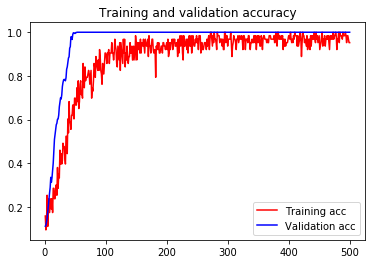

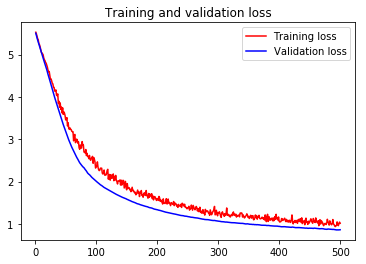

1.0
my_model_neu_ngrams Test Accuracy: 0.910


In [14]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


from keras import layers, Input
from keras.models import Sequential, Model, load_model
from keras import optimizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt


neu_ng = Sequential()
neu_ng.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                               input_shape=(scaled_train_data_ngrams.shape[1],)))
neu_ng.add(layers.Dropout(0.3))
neu_ng.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu_ng.add(layers.Dropout(0.3))
neu_ng.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu_ng.add(layers.Dropout(0.3))
neu_ng.add(layers.Dense(len(set(train_labels)), activation='softmax'))

neu_ng.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
neu_ng.summary()
history = neu_ng.fit(X_scaled_train_data_ngrams, y_train,
                    validation_data=(X_scaled_val_data_ngrams, y_val),
                    epochs=500,
                    batch_size=class_size,
                    callbacks=callbacks_list_neu_ngrams,
                    verbose= 1
                   )
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
print(max(val_acc))
l_model = load_model('my_model_neu_ngrams.h5')
yhat = l_model.predict(scaled_test_data_ngrams)
yhat = argmax(yhat, axis=1)
acc = accuracy_score(test_labels, yhat)
print('my_model_neu_ngrams Test Accuracy: %.3f' % acc)


In [9]:
l_model = load_model('my_model_neu_ngrams.h5')
yhat = l_model.predict(scaled_test_data_ngrams)
yhat = argmax(yhat, axis=1)
acc = accuracy_score(test_labels, yhat)
print('my_model_neu_ngrams Test Accuracy: %.3f' % acc)

my_model_neu_ngrams Test Accuracy: 0.895


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 32)                243968    
_________________________________________________________________
dropout_29 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_30 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_31 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 9)                 585       
Total para

63/63 [==============================] - 0s 3ms/step - loss: 3.1178 - acc: 0.7460 - val_loss: 2.8132 - val_acc: 1.0000
Epoch 54/500
63/63 [==============================] - 0s 3ms/step - loss: 3.0888 - acc: 0.7302 - val_loss: 2.7726 - val_acc: 1.0000
Epoch 55/500
63/63 [==============================] - 0s 3ms/step - loss: 2.9782 - acc: 0.7778 - val_loss: 2.7300 - val_acc: 1.0000
Epoch 56/500
63/63 [==============================] - 0s 3ms/step - loss: 2.9333 - acc: 0.7778 - val_loss: 2.6888 - val_acc: 1.0000
Epoch 57/500
63/63 [==============================] - 0s 3ms/step - loss: 2.9697 - acc: 0.7460 - val_loss: 2.6517 - val_acc: 1.0000
Epoch 58/500
63/63 [==============================] - 0s 3ms/step - loss: 2.9165 - acc: 0.7937 - val_loss: 2.6147 - val_acc: 1.0000
Epoch 59/500
63/63 [==============================] - 0s 3ms/step - loss: 2.8910 - acc: 0.7778 - val_loss: 2.5758 - val_acc: 1.0000
Epoch 60/500
63/63 [==============================] - 0s 3ms/step - loss: 2.8787 - acc: 0

63/63 [==============================] - 0s 3ms/step - loss: 1.8320 - acc: 0.9365 - val_loss: 1.5362 - val_acc: 1.0000
Epoch 116/500
63/63 [==============================] - 0s 3ms/step - loss: 1.8082 - acc: 0.9524 - val_loss: 1.5275 - val_acc: 1.0000
Epoch 117/500
63/63 [==============================] - 0s 3ms/step - loss: 1.8277 - acc: 0.9048 - val_loss: 1.5205 - val_acc: 1.0000
Epoch 118/500
63/63 [==============================] - 0s 3ms/step - loss: 1.9039 - acc: 0.8730 - val_loss: 1.5124 - val_acc: 1.0000
Epoch 119/500
63/63 [==============================] - 0s 3ms/step - loss: 1.9343 - acc: 0.8254 - val_loss: 1.5056 - val_acc: 1.0000
Epoch 120/500
63/63 [==============================] - 0s 3ms/step - loss: 1.7732 - acc: 0.9683 - val_loss: 1.4994 - val_acc: 1.0000
Epoch 121/500
63/63 [==============================] - 0s 3ms/step - loss: 1.8262 - acc: 0.8889 - val_loss: 1.4947 - val_acc: 1.0000
Epoch 122/500
63/63 [==============================] - 0s 3ms/step - loss: 1.8704 -

Epoch 177/500
63/63 [==============================] - 0s 3ms/step - loss: 1.4232 - acc: 0.9524 - val_loss: 1.2433 - val_acc: 1.0000
Epoch 178/500
63/63 [==============================] - 0s 3ms/step - loss: 1.5781 - acc: 0.9365 - val_loss: 1.2398 - val_acc: 1.0000
Epoch 179/500
63/63 [==============================] - 0s 3ms/step - loss: 1.4791 - acc: 0.9524 - val_loss: 1.2382 - val_acc: 1.0000
Epoch 180/500
63/63 [==============================] - 0s 3ms/step - loss: 1.6491 - acc: 0.8730 - val_loss: 1.2393 - val_acc: 1.0000
Epoch 181/500
63/63 [==============================] - 0s 3ms/step - loss: 1.5206 - acc: 0.9524 - val_loss: 1.2409 - val_acc: 1.0000
Epoch 182/500
63/63 [==============================] - 0s 3ms/step - loss: 1.5832 - acc: 0.8889 - val_loss: 1.2416 - val_acc: 1.0000
Epoch 183/500
63/63 [==============================] - 0s 3ms/step - loss: 1.4666 - acc: 0.9365 - val_loss: 1.2396 - val_acc: 1.0000
Epoch 184/500
63/63 [==============================] - 0s 3ms/step - 

63/63 [==============================] - 0s 3ms/step - loss: 1.3311 - acc: 0.9841 - val_loss: 1.1189 - val_acc: 1.0000
Epoch 239/500
63/63 [==============================] - 0s 3ms/step - loss: 1.3600 - acc: 0.9524 - val_loss: 1.1156 - val_acc: 1.0000
Epoch 240/500
63/63 [==============================] - 0s 3ms/step - loss: 1.3031 - acc: 0.9683 - val_loss: 1.1138 - val_acc: 1.0000
Epoch 241/500
63/63 [==============================] - 0s 3ms/step - loss: 1.3826 - acc: 0.9683 - val_loss: 1.1131 - val_acc: 1.0000
Epoch 242/500
63/63 [==============================] - 0s 3ms/step - loss: 1.3920 - acc: 0.9524 - val_loss: 1.1150 - val_acc: 1.0000
Epoch 243/500
63/63 [==============================] - 0s 3ms/step - loss: 1.3688 - acc: 0.9365 - val_loss: 1.1151 - val_acc: 1.0000
Epoch 244/500
63/63 [==============================] - 0s 3ms/step - loss: 1.3755 - acc: 0.9683 - val_loss: 1.1141 - val_acc: 1.0000
Epoch 245/500
63/63 [==============================] - 0s 3ms/step - loss: 1.4192 -

Epoch 300/500
63/63 [==============================] - 0s 3ms/step - loss: 1.2061 - acc: 0.9683 - val_loss: 1.0280 - val_acc: 1.0000
Epoch 301/500
63/63 [==============================] - 0s 3ms/step - loss: 1.2743 - acc: 0.9048 - val_loss: 1.0301 - val_acc: 1.0000
Epoch 302/500
63/63 [==============================] - 0s 3ms/step - loss: 1.2927 - acc: 0.9524 - val_loss: 1.0330 - val_acc: 1.0000
Epoch 303/500
63/63 [==============================] - 0s 3ms/step - loss: 1.1870 - acc: 1.0000 - val_loss: 1.0328 - val_acc: 1.0000
Epoch 304/500
63/63 [==============================] - 0s 3ms/step - loss: 1.1334 - acc: 1.0000 - val_loss: 1.0276 - val_acc: 1.0000
Epoch 305/500
63/63 [==============================] - 0s 3ms/step - loss: 1.1802 - acc: 1.0000 - val_loss: 1.0233 - val_acc: 1.0000
Epoch 306/500
63/63 [==============================] - 0s 3ms/step - loss: 1.1761 - acc: 0.9683 - val_loss: 1.0218 - val_acc: 1.0000
Epoch 307/500
63/63 [==============================] - 0s 3ms/step - 

63/63 [==============================] - 0s 3ms/step - loss: 1.2206 - acc: 0.9683 - val_loss: 0.9663 - val_acc: 1.0000
Epoch 362/500
63/63 [==============================] - 0s 3ms/step - loss: 1.1117 - acc: 1.0000 - val_loss: 0.9655 - val_acc: 1.0000
Epoch 363/500
63/63 [==============================] - 0s 3ms/step - loss: 1.1944 - acc: 0.9365 - val_loss: 0.9651 - val_acc: 1.0000
Epoch 364/500
63/63 [==============================] - 0s 3ms/step - loss: 1.1104 - acc: 0.9524 - val_loss: 0.9688 - val_acc: 1.0000
Epoch 365/500
63/63 [==============================] - 0s 3ms/step - loss: 1.1259 - acc: 1.0000 - val_loss: 0.9692 - val_acc: 1.0000
Epoch 366/500
63/63 [==============================] - 0s 3ms/step - loss: 1.1318 - acc: 0.9683 - val_loss: 0.9676 - val_acc: 1.0000
Epoch 367/500
63/63 [==============================] - 0s 3ms/step - loss: 1.1654 - acc: 0.9365 - val_loss: 0.9659 - val_acc: 1.0000
Epoch 368/500
63/63 [==============================] - 0s 3ms/step - loss: 1.0738 -

Epoch 423/500
63/63 [==============================] - 0s 3ms/step - loss: 0.9919 - acc: 1.0000 - val_loss: 0.9251 - val_acc: 1.0000
Epoch 424/500
63/63 [==============================] - 0s 3ms/step - loss: 1.0700 - acc: 0.9841 - val_loss: 0.9192 - val_acc: 1.0000
Epoch 425/500
63/63 [==============================] - 0s 3ms/step - loss: 1.0230 - acc: 1.0000 - val_loss: 0.9155 - val_acc: 1.0000
Epoch 426/500
63/63 [==============================] - 0s 3ms/step - loss: 1.0546 - acc: 0.9524 - val_loss: 0.9136 - val_acc: 1.0000
Epoch 427/500
63/63 [==============================] - 0s 3ms/step - loss: 1.0123 - acc: 0.9841 - val_loss: 0.9117 - val_acc: 1.0000
Epoch 428/500
63/63 [==============================] - 0s 3ms/step - loss: 1.1421 - acc: 0.9365 - val_loss: 0.9143 - val_acc: 1.0000
Epoch 429/500
63/63 [==============================] - 0s 3ms/step - loss: 1.0389 - acc: 1.0000 - val_loss: 0.9151 - val_acc: 1.0000
Epoch 430/500
63/63 [==============================] - 0s 3ms/step - 

Epoch 484/500
63/63 [==============================] - 0s 3ms/step - loss: 0.9880 - acc: 0.9841 - val_loss: 0.8676 - val_acc: 1.0000
Epoch 485/500
63/63 [==============================] - 0s 3ms/step - loss: 0.9781 - acc: 0.9841 - val_loss: 0.8658 - val_acc: 1.0000
Epoch 486/500
63/63 [==============================] - 0s 3ms/step - loss: 0.9736 - acc: 0.9841 - val_loss: 0.8637 - val_acc: 1.0000
Epoch 487/500
63/63 [==============================] - 0s 3ms/step - loss: 1.0432 - acc: 0.9841 - val_loss: 0.8630 - val_acc: 1.0000
Epoch 488/500
63/63 [==============================] - 0s 3ms/step - loss: 1.0780 - acc: 0.9524 - val_loss: 0.8646 - val_acc: 1.0000
Epoch 489/500
63/63 [==============================] - 0s 3ms/step - loss: 0.9783 - acc: 1.0000 - val_loss: 0.8658 - val_acc: 1.0000
Epoch 490/500
63/63 [==============================] - 0s 3ms/step - loss: 0.9907 - acc: 1.0000 - val_loss: 0.8645 - val_acc: 1.0000
Epoch 491/500
63/63 [==============================] - 0s 3ms/step - 

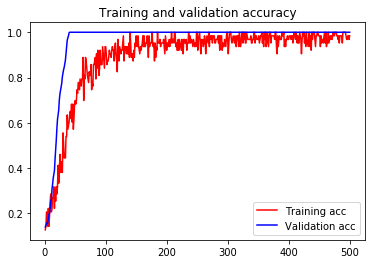

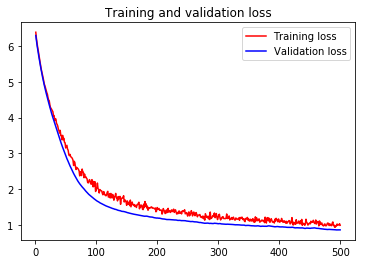

1.0
my_model_neu_words Test Accuracy: 0.902


In [15]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


from keras import layers, Input
from keras.models import Sequential, Model
from keras import optimizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt


neu_wo = Sequential()
neu_wo.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                               input_shape=(scaled_train_data_words.shape[1],)))
neu_wo.add(layers.Dropout(0.3))
neu_wo.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu_wo.add(layers.Dropout(0.3))
neu_wo.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu_wo.add(layers.Dropout(0.3))
neu_wo.add(layers.Dense(len(set(train_labels)), activation='softmax'))


neu_wo.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
neu_wo.summary()
history = neu_wo.fit(X_scaled_train_data_words, y_train,
                    validation_data=(X_scaled_val_data_words, y_val),
                    epochs=500,
                    batch_size=class_size,
                    callbacks=callbacks_list_neu_words,
                    verbose= 1
                   )
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
print(max(val_acc))
l_model = load_model('my_model_neu_words.h5')
yhat = l_model.predict( scaled_test_data_words)
yhat = argmax(yhat, axis=1)
acc = accuracy_score(test_labels, yhat)
print('my_model_neu_words Test Accuracy: %.3f' % acc)

In [ ]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


from keras import layers, Input
from keras.models import Sequential, Model, load_model
from keras import optimizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

word_input_tensor = Input(shape=(scaled_train_data_words.shape[1],) , name='words')
ngram_input_tensor = Input(shape=(scaled_train_data_ngrams.shape[1],) , name='n_grams')

neu0 = Sequential()
neu0.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                               input_shape=(scaled_train_data_ngrams.shape[1],)))
neu0.add(layers.Dropout(0.3))
neu0.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu0.add(layers.Dropout(0.3))
neu0.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu0.add(layers.Dropout(0.3))

neu1 = Sequential()
neu1.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                               input_shape=(scaled_train_data_words.shape[1],)))
neu1.add(layers.Dropout(0.3))
neu1.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu1.add(layers.Dropout(0.3))
neu1.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu1.add(layers.Dropout(0.3))

output_tensor_0 = neu0(ngram_input_tensor)
output_tensor_1 = neu1(word_input_tensor)


# conv_input_tensor = Input(shape=(maxlen,) , name='convnets')

# conv_1d_s3_model = Sequential()
# conv_1d_s3_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
# conv_1d_s3_model.add(layers.Dropout(0.2))
# conv_1d_s3_model.add(layers.SeparableConv1D(32, 3, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
# conv_1d_s3_model.add(layers.BatchNormalization())
# conv_1d_s3_model.add(layers.GlobalMaxPooling1D())

# conv_output_tensor_0 = conv_1d_s3_model(conv_input_tensor)


# conv_1d_s1_model = Sequential()
# conv_1d_s1_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
# conv_1d_s1_model.add(layers.Dropout(0.2))
# conv_1d_s1_model.add(layers.SeparableConv1D(32, 1, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
# conv_1d_s1_model.add(layers.BatchNormalization())
# conv_1d_s1_model.add(layers.GlobalMaxPooling1D())

# conv_output_tensor_1 = conv_1d_s1_model(conv_input_tensor)

# conv_1d_complex_model = Sequential()
# conv_1d_complex_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
# conv_1d_complex_model.add(layers.Dropout(0.2))
# conv_1d_complex_model.add(layers.SeparableConv1D(32, 2, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
# conv_1d_complex_model.add(layers.BatchNormalization())
# conv_1d_complex_model.add(layers.GlobalMaxPooling1D())

# conv_output_tensor_2 = conv_1d_complex_model(conv_input_tensor)



concatenated = layers.concatenate([output_tensor_0,
                                   output_tensor_1,
#                                    conv_output_tensor_0,
#                                    conv_output_tensor_1,
#                                    conv_output_tensor_2,
                                  ], axis=-1)

concatenated = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(concatenated)
concatenated = layers.Dropout(0.3)(concatenated)
concatenated = layers.Dense(len(set(train_labels)), activation='softmax')(concatenated)

model = Model([ngram_input_tensor, word_input_tensor,
#                conv_input_tensor
              ], concatenated)
model.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()
print(X_scaled_train_data_ngrams.shape, X_scaled_train_data_words.shape, y_train.shape) 
history = model.fit([X_scaled_train_data_ngrams, X_scaled_train_data_words, 
#                      X_train
                    ], y_train,
                    validation_data=([X_scaled_val_data_ngrams, X_scaled_val_data_words,
#                                       X_val
                                     ], y_val),
                    epochs=500,
                    batch_size=class_size,
                    callbacks=callbacks_list_neu,
                    verbose= 1
                   )
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
print(max(val_acc))
l_model = load_model('my_model_neu.h5')
yhat = l_model.predict([scaled_test_data_ngrams, scaled_test_data_words])
yhat = argmax(yhat, axis=1)
acc = accuracy_score(test_labels, yhat)
print('my_model_neu Test Accuracy: %.3f' % acc)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
n_grams (InputLayer)            (None, 4152)         0                                            
__________________________________________________________________________________________________
words (InputLayer)              (None, 7623)         0                                            
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 64)           139168      n_grams[0][0]                    
__________________________________________________________________________________________________
sequential_13 (Sequential)      (None, 64)           250240      words[0][0]                      
__________________________________________________________________________________________________
concatenat

63/63 [==============================] - 0s 6ms/step - loss: 5.9306 - acc: 0.7460 - val_loss: 5.5691 - val_acc: 0.8968
Epoch 47/500
63/63 [==============================] - 0s 6ms/step - loss: 5.7937 - acc: 0.7778 - val_loss: 5.4872 - val_acc: 0.9034
Epoch 48/500
63/63 [==============================] - 0s 6ms/step - loss: 5.7236 - acc: 0.7619 - val_loss: 5.4017 - val_acc: 0.9034
Epoch 49/500
63/63 [==============================] - 0s 6ms/step - loss: 5.6883 - acc: 0.7619 - val_loss: 5.3246 - val_acc: 0.9087
Epoch 50/500
63/63 [==============================] - 0s 6ms/step - loss: 5.5955 - acc: 0.6825 - val_loss: 5.2473 - val_acc: 0.9405
Epoch 51/500
63/63 [==============================] - 0s 6ms/step - loss: 5.5795 - acc: 0.7143 - val_loss: 5.1763 - val_acc: 0.9603
Epoch 52/500
63/63 [==============================] - 0s 6ms/step - loss: 5.5800 - acc: 0.6825 - val_loss: 5.1095 - val_acc: 0.9497
Epoch 53/500
63/63 [==============================] - 0s 6ms/step - loss: 5.4642 - acc: 0

63/63 [==============================] - 0s 6ms/step - loss: 3.5732 - acc: 0.9365 - val_loss: 3.2996 - val_acc: 1.0000
Epoch 109/500
63/63 [==============================] - 0s 6ms/step - loss: 3.4922 - acc: 0.9841 - val_loss: 3.2808 - val_acc: 1.0000
Epoch 110/500
63/63 [==============================] - 0s 6ms/step - loss: 3.4557 - acc: 0.9683 - val_loss: 3.2591 - val_acc: 1.0000
Epoch 111/500
63/63 [==============================] - 0s 6ms/step - loss: 3.5380 - acc: 0.9206 - val_loss: 3.2453 - val_acc: 1.0000
Epoch 112/500
63/63 [==============================] - 0s 6ms/step - loss: 3.6174 - acc: 0.8730 - val_loss: 3.2429 - val_acc: 1.0000
Epoch 113/500
63/63 [==============================] - 0s 6ms/step - loss: 3.5340 - acc: 0.9048 - val_loss: 3.2329 - val_acc: 1.0000
Epoch 114/500
63/63 [==============================] - 0s 6ms/step - loss: 3.5364 - acc: 0.9206 - val_loss: 3.2142 - val_acc: 1.0000
Epoch 115/500
63/63 [==============================] - 0s 6ms/step - loss: 3.4932 -

Epoch 170/500
63/63 [==============================] - 0s 6ms/step - loss: 2.8795 - acc: 0.9524 - val_loss: 2.6212 - val_acc: 1.0000
Epoch 171/500
63/63 [==============================] - 0s 6ms/step - loss: 2.7265 - acc: 1.0000 - val_loss: 2.6151 - val_acc: 1.0000
Epoch 172/500
63/63 [==============================] - 0s 6ms/step - loss: 2.7944 - acc: 0.9683 - val_loss: 2.6047 - val_acc: 1.0000
Epoch 173/500
63/63 [==============================] - 0s 6ms/step - loss: 2.8044 - acc: 0.9683 - val_loss: 2.5979 - val_acc: 1.0000
Epoch 174/500
63/63 [==============================] - 0s 6ms/step - loss: 2.8285 - acc: 0.9365 - val_loss: 2.5902 - val_acc: 1.0000
Epoch 175/500
63/63 [==============================] - 0s 6ms/step - loss: 2.7468 - acc: 0.9841 - val_loss: 2.5846 - val_acc: 1.0000
Epoch 176/500
63/63 [==============================] - 0s 6ms/step - loss: 2.7245 - acc: 0.9683 - val_loss: 2.5756 - val_acc: 1.0000
Epoch 177/500
63/63 [==============================] - 0s 6ms/step - 

63/63 [==============================] - 0s 6ms/step - loss: 2.3996 - acc: 0.9841 - val_loss: 2.2438 - val_acc: 1.0000
Epoch 232/500
63/63 [==============================] - 0s 6ms/step - loss: 2.3930 - acc: 0.9841 - val_loss: 2.2397 - val_acc: 1.0000
Epoch 233/500
63/63 [==============================] - 0s 6ms/step - loss: 2.3815 - acc: 0.9683 - val_loss: 2.2339 - val_acc: 1.0000
Epoch 234/500
63/63 [==============================] - 0s 6ms/step - loss: 2.3239 - acc: 1.0000 - val_loss: 2.2237 - val_acc: 1.0000
Epoch 235/500
63/63 [==============================] - 0s 6ms/step - loss: 2.4295 - acc: 0.9365 - val_loss: 2.2240 - val_acc: 1.0000
Epoch 236/500
63/63 [==============================] - 0s 6ms/step - loss: 2.4280 - acc: 0.9524 - val_loss: 2.2293 - val_acc: 1.0000
Epoch 237/500
63/63 [==============================] - 0s 6ms/step - loss: 2.4047 - acc: 0.9683 - val_loss: 2.2328 - val_acc: 1.0000
Epoch 238/500
63/63 [==============================] - 0s 6ms/step - loss: 2.4049 -

Epoch 293/500
63/63 [==============================] - 0s 6ms/step - loss: 2.1952 - acc: 0.9206 - val_loss: 1.9861 - val_acc: 1.0000
Epoch 294/500
63/63 [==============================] - 0s 6ms/step - loss: 2.1145 - acc: 1.0000 - val_loss: 1.9881 - val_acc: 1.0000
Epoch 295/500
63/63 [==============================] - 0s 6ms/step - loss: 2.1992 - acc: 0.9365 - val_loss: 1.9847 - val_acc: 1.0000
Epoch 296/500
63/63 [==============================] - 0s 6ms/step - loss: 2.1139 - acc: 0.9841 - val_loss: 1.9825 - val_acc: 1.0000
Epoch 297/500
63/63 [==============================] - 0s 6ms/step - loss: 2.1149 - acc: 0.9841 - val_loss: 1.9800 - val_acc: 1.0000
Epoch 298/500
63/63 [==============================] - 0s 6ms/step - loss: 2.0445 - acc: 1.0000 - val_loss: 1.9695 - val_acc: 1.0000
Epoch 299/500
63/63 [==============================] - 0s 6ms/step - loss: 2.0732 - acc: 1.0000 - val_loss: 1.9590 - val_acc: 1.0000
Epoch 300/500
63/63 [==============================] - 0s 6ms/step - 

In [ ]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


from keras import layers, Input
from keras.models import Sequential, Model
from keras import optimizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

convnet_input_tensor = Input(shape=(maxlen,) , name='convnet_words')

conv_1d_s3_model = Sequential()
conv_1d_s3_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
conv_1d_s3_model.add(layers.Dropout(0.3))
conv_1d_s3_model.add(layers.SeparableConv1D(64, 3, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
conv_1d_s3_model.add(layers.BatchNormalization())
conv_1d_s3_model.add(layers.GlobalMaxPooling1D())
# conv_1d_s3_model.add(layers.BatchNormalization())
# conv_1d_s3_model.add(layers.Dense(len(set(train_labels)), activation='softmax'))

# conv_1d_s3_model.layers[0].set_weights([w2d.word_embedding])
# conv_1d_s3_model.layers[0].trainable = False
conv_output_tensor_0 = conv_1d_s3_model(convnet_input_tensor)


conv_1d_s1_model = Sequential()
conv_1d_s1_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
conv_1d_s1_model.add(layers.Dropout(0.3))
conv_1d_s1_model.add(layers.SeparableConv1D(64, 1, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
conv_1d_s1_model.add(layers.BatchNormalization())
# conv_1d_s1_model.add(layers.MaxPooling1D(2))
# conv_1d_s1_model.add(layers.SeparableConv1D(32, 3, activation='relu'))
conv_1d_s1_model.add(layers.GlobalMaxPooling1D())
# conv_1d_s1_model.add(layers.BatchNormalization())
# conv_1d_s1_model.add(layers.Dense(len(set(train_labels)), activation='softmax'))

# conv_1d_s1_model.layers[0].set_weights([w2d.word_embedding])
# conv_1d_s1_model.layers[0].trainable = False
conv_output_tensor_1 = conv_1d_s1_model(convnet_input_tensor)

conv_1d_complex_model = Sequential()
conv_1d_complex_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
conv_1d_complex_model.add(layers.Dropout(0.3))
conv_1d_complex_model.add(layers.SeparableConv1D(64, 2, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
conv_1d_complex_model.add(layers.BatchNormalization())
# conv_1d_complex_model.add(layers.SeparableConv1D(64, 3, activation='relu'))
# conv_1d_complex_model.add(layers.MaxPooling1D(2))
# conv_1d_complex_model.add(layers.SeparableConv1D(64, 3, activation='relu'))
# conv_1d_complex_model.add(layers.SeparableConv1D(128, 3, activation='relu'))
# conv_1d_complex_model.add(layers.MaxPooling1D(2))
# conv_1d_complex_model.add(layers.SeparableConv1D(64, 3, activation='relu'))
# conv_1d_complex_model.add(layers.SeparableConv1D(128, 3, activation='relu'))
conv_1d_complex_model.add(layers.GlobalMaxPooling1D())
# conv_1d_complex_model.add(layers.BatchNormalization())
# conv_1d_s1_model.add(layers.Dense(len(set(train_labels)), activation='softmax'))

# conv_1d_complex_model.layers[0].set_weights([w2d.word_embedding])
# conv_1d_complex_model.layers[0].trainable = False
conv_output_tensor_2 = conv_1d_complex_model(convnet_input_tensor)

# x = layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen)(word_input_tensor)
# x = layers.Conv1D(128, 5, activation='relu', padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(x)
# x = layers.Dropout(0.2)(x)
# x = layers.BatchNormalization()(x)
# y = layers.Conv1D(128, 10, activation='relu', padding='same')(x)
# added = layers.add([y, x])
# added = layers.GlobalMaxPooling1D()(added)

concatenated = layers.concatenate([conv_output_tensor_0,
                                   conv_output_tensor_1,
                                   conv_output_tensor_2,
#                                    ,added
                                  ], axis=-1)
concatenated = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(concatenated)
concatenated = layers.Dropout(0.3)(concatenated)
concatenated = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(concatenated)
concatenated = layers.Dropout(0.3)(concatenated)
answer = layers.Dense(len(set(train_labels)), activation='softmax')(concatenated)

model = Model(convnet_input_tensor, answer)
model.summary()

# model.layers[0].set_weights([w2d.word_embedding])
# model.layers[0].trainable = False

model.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=1000,
                    batch_size=class_size,
                    callbacks=callbacks_list_convnet,
                    verbose= 2
                   )

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
l_model = load_model('my_model_convnet.h5')
yhat = l_model.predict(X_test)
yhat = argmax(yhat, axis=1)
acc = accuracy_score(test_labels, yhat)
print('my_model_convnet Test Accuracy: %.3f' % acc)

In [ ]:
print(max(val_acc))

In [ ]:
from keras.models import load_model
from keras.utils import to_categorical
from numpy import dstack
from keras.utils import plot_model
from keras.layers.merge import concatenate

# load models from file
def load_all_models(model_names_list):
    all_models = list()
    for model_name in model_names_list:
        # define filename for this ensemble
#         filename = 'models/model_' + str(i + 1) + '.h5'
        filename = model_name + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models


# define stacked model from multiple member input models
def define_stacked_model(members):
    # update all layers in all models to not be trainable
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            # make not trainable
            layer.trainable = False
            # rename to avoid 'unique layer name' issue
            layer.name = 'ensemble_' + str(i + 1) + '_' + layer.name
    # define multi-headed input
    ensemble_visible = [model.input for model in members]
#     print(ensemble_visible)
#     ensemble_visible = [[ngram_input_tensor, word_input_tensor], convnet_input_tensor]
    # concatenate merge output from each model
    ensemble_outputs = [model.output for model in members]
#     ensemble_outputs = [concatenated, answer]
    merge = concatenate(ensemble_outputs)
    hidden = layers.Dense(128, activation='relu')(merge)
    hidden = layers.Dropout(0.3)(hidden)
    output = layers.Dense(len(set(train_labels)), activation='softmax')(hidden)
    model = Model(inputs=ensemble_visible, outputs=output)
    # plot graph of ensemble
#     plot_model(model, show_shapes=True, to_file='model_graph.png')
    # compile
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=3e-4), metrics=['accuracy'])
    return model

# fit a stacked model
def fit_stacked_model(model, inputX, inputy, valX, valy):
    # prepare input data
#     X = [inputX for _ in range(len(model.input))]
    # encode output data
#     inputy_enc = to_categorical(inputy)
    # fit model
    model.fit(inputX, inputy, validation_data=(valX, valy), batch_size=class_size,
              callbacks=callbacks_list_stacked, epochs=500, verbose=1)
    
# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
    # prepare input data
#     X = [inputX for _ in range(len(model.input))]
    # make prediction
    return model.predict(inputX, verbose=0)

print('done!')

In [ ]:

members = load_all_models(['my_model_neu_ngrams', 'my_model_neu_words', 'my_model_convnet'])
print('Loaded %d models' % len(members))
# define ensemble model
stacked_model = define_stacked_model(members)
# fit stacked model on test dataset
fit_stacked_model(stacked_model, [X_scaled_train_data_ngrams, X_scaled_train_data_words, X_train], y_train, [X_scaled_val_data_ngrams, X_scaled_val_data_words, X_val], y_val)
final_model = load_model('my_model_neu_stacked.h5')
# make predictions and evaluate
yhat = predict_stacked_model(stacked_model, [scaled_test_data_ngrams, scaled_test_data_words, test_data])
yhat = argmax(yhat, axis=1)
acc = accuracy_score(test_labels, yhat)
print('Stacked Test Accuracy: %.3f' % acc)